In [39]:
# Import packages
import os
import shutil
import pandas as pd
from PIL import Image

## Load packages. Build dataset for the first time

In [45]:
# Read file with labels
xl_file = pd.ExcelFile('HP_WSI-CoordAnnotatedPatches.xlsx')

dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}

df = dfs['Sheet1']
df = df.loc[df['Presence'] != 0] # Delete uncertain cases

In [46]:
def rename_and_save_images(source_folder, destination_folder, data):
    ''' 
    Function to put the patient_id, window_id and label of each image
    within its name, in order to be able to move all images to the
    same folder and process them individually without having to look
    for its information somewhere else.
    data is a dataframe with the information of the images
    '''

    # Step 1: Create destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        print(f"Created folder: {destination_folder}")    
    
    # Step 2: Loop through each patient folder
    for patient in data['Pat_ID'].unique():
        pat_path = os.path.join(source_folder, patient+'_0') 
        # Check if the patient folder exists
        if not os.path.exists(pat_path):
            print(f"Patient folder does not exist: {pat_path}")
            continue
        
        # Step 3: Get list of all image files in the source folder
        image_files = [f for f in os.listdir(pat_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        
        # Step 4: Rename and save each image to the destination folder
        for filename in image_files:
            # Define the new file name 
            window_id = filename.split('_')[0].split('.')[0].lstrip('0')
            if window_id == '':
                window_id = 0

            label = data.loc[data['Pat_ID'] == patient]            
            label = label.loc[label['Window_ID'] == int(window_id)]
            if label.empty:
                continue

            name = os.path.splitext(filename)[0].lstrip('0')
            if name == '':
                name = '0'
                
            new_filename = f"{patient}__{name}__{label.iloc[0]['Presence']}{os.path.splitext(filename)[1]}"
            
            # Define full path for source and destination
            src_path = os.path.join(pat_path, filename)
            dst_path = os.path.join(destination_folder, new_filename)
            
            # Copy and rename the file
            shutil.copy(src_path, dst_path)

In [47]:
# Calling function to process train set
source_folder = "Raw_Train_Set"
destination_folder = "Training_Set"
rename_and_save_images(source_folder, destination_folder, data=df)

Created folder: Training_Set


## Read new dataset

In [48]:
def read_images(folder):
    '''
    Function to retrieve the dataset. It returns a list with all the images retrieved.
    Each element of the list consists of a dictionary with two keys: 'img' and 'info'.
    The 'img' key contains the image itself.
    The 'info' key contains a list with information about the image -> [patient, window_id, label] All elements of the list are strings
    '''
    # Check if the folder exists
    if not os.path.exists(folder):
        print(f"Folder does not exist: {folder}")  

    # Read images
    images = []
    for img in os.listdir(folder):
        if img.endswith(('.png', '.jpg', '.jpeg')):
            temp_path = os.path.join(folder, img)

            temp_dict = {}  
            temp_dict['img'] = Image.open(temp_path).convert("RGB") # Image in RGB ready to be processed          
            temp_dict['info'] = os.path.splitext(img)[0].split('__') # List with the image information
            images.append(temp_dict)
    
    return images

In [49]:
# Calling function to read train set
folder = "Training_Set"
images = read_images(folder)

In [50]:
len(images)

2508

In [51]:
# 1 has the bacteria 
# -1 does not have the bacteria
images[31] 

{'img': <PIL.Image.Image image mode=RGB size=256x256>,
 'info': ['B22-102', '3838', '-1']}

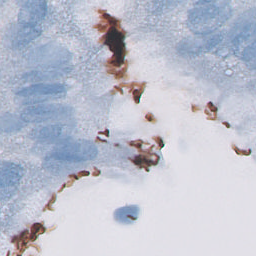

In [52]:
display(images[69]['img'])

In [54]:
import pickle
# Save images onto a pickle file
with open('images.pkl', 'wb') as f:
    pickle.dump(images, f)